# Advanced Tallies in OpenMC

In [1]:
import openmc
import openmc.lib
import numpy as np 
from matplotlib import pyplot as plt

# Model Setup

In this section we'll look at constructing more advanced tallies with OpenMC. A model that warrants advanced tallies is necessarily more complex than a pincell, so we're going to use the built-in PWR assembly model in OpenMC.

In [2]:
assembly_model = openmc.examples.pwr_assembly()

As we did before, let's plot the model and view the materials to see what we're working with.

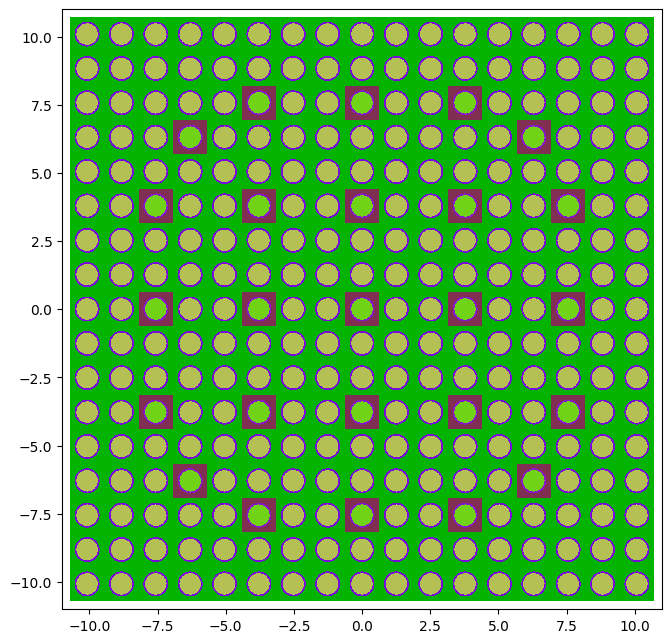

In [3]:
assembly_model.geometry.root_universe.plot(width=(22, 22), pixels=(600, 600))

In [4]:
assembly_model.materials

[Material
 	ID             =	1
 	Name           =	Fuel
 	Temperature    =	None
 	Density        =	10.29769 [g/cm3]
 	Volume         =	None [cm^3]
 	S(a,b) Tables  
 	Nuclides       
 	U234           =	4.4843e-06   [ao]
 	U235           =	0.00055815   [ao]
 	U238           =	0.022408     [ao]
 	O16            =	0.045829     [ao],
 Material
 	ID             =	2
 	Name           =	Cladding
 	Temperature    =	None
 	Density        =	6.55 [g/cm3]
 	Volume         =	None [cm^3]
 	S(a,b) Tables  
 	Nuclides       
 	Zr90           =	0.021827     [ao]
 	Zr91           =	0.00476      [ao]
 	Zr92           =	0.0072758    [ao]
 	Zr94           =	0.0073734    [ao]
 	Zr96           =	0.0011879    [ao],
 Material
 	ID             =	3
 	Name           =	Hot borated water
 	Temperature    =	None
 	Density        =	0.740582 [g/cm3]
 	Volume         =	None [cm^3]
 	S(a,b) Tables  
 	S(a,b)         =	('c_H_in_H2O', 1.0)
 	Nuclides       
 	H1             =	0.049457     [ao]
 	O16            =	0.024672   

In order to make some of the plots we'll generate in this session more intuitive, we'll remove the reflecting boundary condition for the upper Y-plane.



In [5]:
assembly_surfaces = assembly_model.geometry.get_all_surfaces()

for surf_id, surface in assembly_surfaces.items():
    if isinstance(surface, openmc.YPlane) and surface.y0 > 0.0:
        surface.boundary_type = 'vacuum'
    if isinstance(surface, openmc.XPlane) and surface.x0 > 0.0:
        surface.boundary_type = 'vacuum'

# Mesh Tallies

OpenMC can tally results onto regular, rectilinear, cylindrical, spherical, and unstructured meshes. Here we'll look at how to setup a regular mesh tally and visualize it for this assembly model. Again, it will be useful to have the bounding box of this model to setup the mesh.

In [6]:
lower_left, upper_right = assembly_model.geometry.bounding_box

mesh = openmc.RegularMesh()
mesh.lower_left = lower_left[:2]
mesh.upper_right = upper_right[:2]
mesh.dimension = (50, 50)
print(mesh)

mesh_filter = openmc.MeshFilter(mesh)

mesh_tally = openmc.Tally()
mesh_tally.filters = [mesh_filter]
mesh_tally.scores = ['flux', 'heating']


RegularMesh
	ID             =	1
	Name           =	
	Dimensions     =	2
	Voxels         =	(50, 50)
	Lower left     =	[-10.71 -10.71]
	Upper Right    =	[10.71 10.71]
	Width          =	None



Learning from our last session on tallies, we'll include a tally with all of the scores needed for determining the neutron source.

In [7]:
heating_tally = openmc.Tally()
power = 17.34e6 # power in Watts
heating_tally.scores = ['heating']

## Tally Triggers


OpenMC has the ability to halt a simulation when a certain condition on the tally is met. These conditions can be set using the variance, standardn deviation, or relative error. Here we'll tell the simulation to stop when the our heating value has converged to a relative error of less than 20%.

In [8]:
trigger = openmc.Trigger('rel_err', 0.20)
mesh_tally.triggers = [trigger]

With these tallies setup, we'll apply them and and run the model.

In [9]:
assembly_model.tallies = [mesh_tally, heating_tally]

assembly_model.settings.trigger_active = True
assembly_model.settings.trigger_batch_interval = 5
assembly_model.settings.trigger_max_batches = 150

assembly_model.settings.particles = 10000
# treated as minimum number of batches with triggers on
assembly_model.settings.batches = 15 
assembly_model.settings.inactive = 10

sp_file = assembly_model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [10]:
with openmc.StatePoint(sp_file) as sp:
    mesh_tally_out = sp.get_tally(id=mesh_tally.id)
    heating_tally_out = sp.get_tally(id=heating_tally.id)

Let's check to make sure that trigger did its job.

In [11]:
mesh_tally_out.get_values(value='rel_err').max()

0.19500668161266188

For practice, let's quickly compute the neutron source normalization factor.

In [12]:
heating = heating_tally_out.get_values(scores=['heating']).sum()
J_to_eV = 1 / 1.6e-19
neutron_source = power * J_to_eV / heating
print(f'Neutron source: {neutron_source:.2e}')

Neutron source: 1.99e+18


For the volume normalization, we'll divide the flux values by the volume of a mesh voxel. Again, we're working with a 2D model so we'll assume an axial length of 1 cm.

In [13]:
volume = np.prod((mesh.upper_right - mesh.lower_left) / mesh.dimension)
print(volume)

0.18352656000000006


In [14]:
mesh_flux = neutron_source * mesh_tally_out.get_values(scores=['flux']) / volume
mesh_flux = mesh_flux.reshape(mesh.dimension)

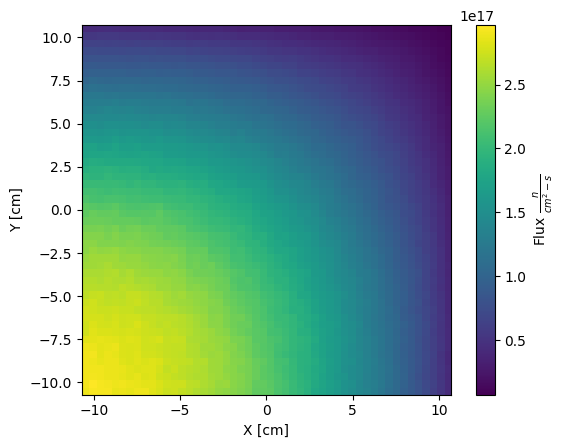

In [15]:
img = plt.imshow(mesh_flux, origin='lower', extent=[-10.71, 10.71, -10.71, 10.71])
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.colorbar(img, label=r'Flux $\frac{n}{cm^{2}-s}$')

The `get_values()` method gives us an array with three dimensions: (filters, nuclides, scores). If you have multiple filters in a tally, the `get_reshaped_data()` method will give you a separate dimension for each filter. For our mesh case, this effectively gives the same thing as `get_values()` since there's only a single filter:

In [16]:
mesh_tally_out.get_reshaped_data().shape

(2500, 1, 2)

However, there is also an `expand_dims` argument that will expand a mesh filter into multiple dimensions:

In [17]:
mesh_data = mesh_tally_out.get_reshaped_data(expand_dims=True)
mesh_data.shape

(50, 50, 1, 2)

Now we can index the array and plot it as we did before:

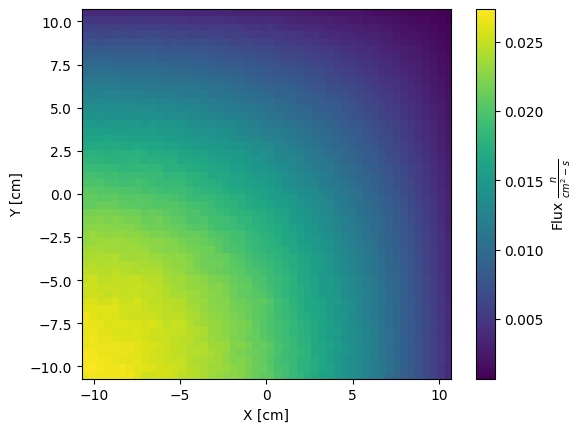

In [18]:
img = plt.imshow(mesh_data[:, :, 0, 0], origin='lower', extent=[-10.71, 10.71, -10.71, 10.71])
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.colorbar(img, label=r'Flux $\frac{n}{cm^{2}-s}$')

Alternatively, we can get a "slice" of the plot that includes only the score we want (flux) by using the `get_slice()` method:

In [19]:
flux_only = mesh_tally_out.get_slice(scores=["flux"])
flux_only.shape

(2500, 1, 1)

Now we can use `get_reshaped_data()` and tell it to "squeeze" any dimensions of size 1.

In [20]:
flux_reshaped = flux_only.get_reshaped_data(expand_dims=True).squeeze()
flux_reshaped.shape

(50, 50)

We can do the same to get the volumetric neutron heating as well.

In [21]:
mesh_heat = power * mesh_tally_out.get_values(scores=['heating']) / heating / volume
mesh_heat = mesh_heat.reshape(mesh.dimension)

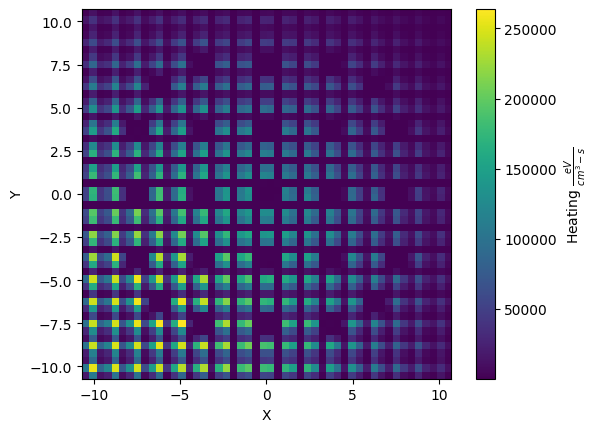

In [22]:
img = plt.imshow(mesh_heat, origin='lower', extent=[-10.71, 10.71, -10.71, 10.71])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(img, label=r'Heating $\frac{eV}{cm^{3}-s}$')

## Distribcells

So this gives us a fairly good idea of what the flux and power distributions look like in this model, but we often want to know the per-pin power generation rate -- something that is hard to post-process with the tallies above. We can use a distribcell tally to produce this information easily.

First, we'll want to create a distribcell tally for the cell containing our fuel material. Based on the list above, our fuel material has the name "Fuel". We'll use that to identify the cell we want to setup a distribcell tally for.

In [23]:
fuel_cell = None

for cell_id, cell in assembly_model.geometry.get_all_material_cells().items():
    if cell.fill.name == 'Fuel':
        fuel_cell = cell
        
print(fuel_cell)

Cell
	ID             =	1
	Name           =	fuel
	Fill           =	Material 1
	Region         =	-1
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



In [24]:
assembly_model.geometry.determine_paths()
print(fuel_cell.num_instances)

264


In [25]:
distribcell_filter = openmc.DistribcellFilter(fuel_cell)

In [26]:
dcell_tally = openmc.Tally()
dcell_tally.filters = [distribcell_filter]
dcell_tally.scores = ['heating']
dcell_tally.triggers = [trigger]

In [27]:
assembly_model.tallies = [dcell_tally]

In [28]:
sp_file = assembly_model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [29]:
with openmc.StatePoint(sp_file) as sp:
    dcell_tally_out = sp.tallies[dcell_tally.id]
    heat_mean = dcell_tally_out.get_values(scores=['heating'])    
    heat_df = dcell_tally_out.get_pandas_dataframe()
heat_df

level 1      level 2         level 3      distribcell nuclide    score  \
       univ cell     lat            univ cell                                
         id   id      id   x   y      id   id                                
0         4    7       3   0   0       1    1           0   total  heating   
1         4    7       3   1   0       1    1           1   total  heating   
2         4    7       3   2   0       1    1           2   total  heating   
3         4    7       3   3   0       1    1           3   total  heating   
4         4    7       3   4   0       1    1           4   total  heating   
..      ...  ...     ...  ..  ..     ...  ...         ...     ...      ...   
259       4    7       3  12  16       1    1         259   total  heating   
260       4    7       3  13  16       1    1         260   total  heating   
261       4    7       3  14  16       1    1         261   total  heating   
262       4    7       3  15  16       1    1         262   total  heating   
263       4    7       3  16  16       1    1         263   total  heating   

        mean std. dev.  
                        
                        
0   3.80e+05  1.75e+04  
1   3.70e+05  1.43e+04  
2   3.84e+05  1.35e+04  
3   3.71e+05  1.32e+04  
4   3.59e+05  8.39e+03  
..       ...       ...  
259 3.28e+04  4.16e+03  
260 2.38e+04  2.31e+03  
261 1.97e+04  2.44e+03  
262 1.62e+04  1.84e+03  
263 7.84e+03  9.16e+02  

[264 rows x 12 columns]

As before, we'll create a normalized mean for the heating tally. A little inspection of the cell allows us to calculated the appropriate volume for the tally.

In [30]:
print(fuel_cell.region)

-1


In [31]:
surfaces = assembly_model.geometry.get_all_surfaces()
fuel_cell_surf = surfaces[1]
print(fuel_cell_surf)

Surface
	ID             =	1
	Name           =	Fuel OR
	Type           =	z-cylinder
	Boundary       =	transmission
	Coefficients   
x0              =	0
y0              =	0
r               =	0.39218



In [32]:
volume = np.pi * fuel_cell_surf.r**2
print(volume)

0.4831931368640985


In [33]:
heat_df['power (W)'] = power * heat_df['mean'] / heating
heat_df['power (kW)'] = 1e-03 * heat_df['power (W)']

In [34]:
pin_powers = heat_df[['level 2', 'level 3', 'distribcell', 'power (kW)']].copy()

In [35]:
pin_powers

level 2         level 3      distribcell  power (kW)
        lat            univ cell                        
         id   x   y      id   id                        
0         3   0   0       1    1           0  121.006918
1         3   1   0       1    1           1  117.850485
2         3   2   0       1    1           2  122.379613
3         3   3   0       1    1           3  118.049637
4         3   4   0       1    1           4  114.255972
..      ...  ..  ..     ...  ...         ...         ...
259       3  12  16       1    1         259   10.449508
260       3  13  16       1    1         260    7.584120
261       3  14  16       1    1         261    6.260857
262       3  15  16       1    1         262    5.149427
263       3  16  16       1    1         263    2.495588

[264 rows x 7 columns]

# Tally Arithmetic

There are many cases in which it is useful to combine the results from different tallies. We've already seen this when computing normalization factors for tallies. OpenMC has the ability to combine (add, subtract, multiply, etc.) tallies using the Python API in order to create _derived tallies_. Since no covariance information is obtained in OpenMC, it is assumed that tallies are completely independent of one another when propagating uncertainties.

In this exercise, we'll use tally arithmetic to compute some standard reactor physics parameters like $k_{eff}$ and $k_{inf}$.

$$k_{eff} = \frac{\langle \nu \Sigma_f \phi \rangle}{\langle \Sigma_a \phi \rangle + \langle L \rangle}$$

$$k_{inf} = p \epsilon f \eta_{T} $$

<!-- $$k_{eff} = p \epsilon f \eta P_{FNL} P_{T
NL}$$ -->

Note that we've tallied most of these scores before. We'll just be approaching calculation of our values of interest in a different way.

First, let's start with a fresh assembly model.

OrderedDict([(4,
              Material
              	ID             =	4
              	Name           =	UO2 (2.4%)
              	Temperature    =	None
              	Density        =	10.29769 [g/cm3]
              	Volume         =	None [cm^3]
              	S(a,b) Tables  
              	Nuclides       
              	U234           =	4.4843e-06   [ao]
              	U235           =	0.00055815   [ao]
              	U238           =	0.022408     [ao]
              	O16            =	0.045829     [ao]),
             (5,
              Material
              	ID             =	5
              	Name           =	Zircaloy
              	Temperature    =	None
              	Density        =	6.55 [g/cm3]
              	Volume         =	None [cm^3]
              	S(a,b) Tables  
              	Nuclides       
              	Zr90           =	0.021827     [ao]
              	Zr91           =	0.00476      [ao]
              	Zr92           =	0.0072758    [ao]
              	Zr94           =	0.00

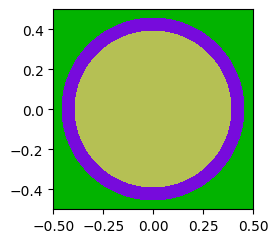

In [36]:
pincell_model = openmc.examples.pwr_pin_cell()
pincell_model.geometry.root_universe.plot()
pincell_model.geometry.get_all_materials()

In [37]:
pincell_model.geometry.bounding_box

(array([-0.63, -0.63,  -inf]), array([0.63, 0.63,  inf]))

To make this exercise a little more interesting, we'll convert it from a 2D model to a 3D model.

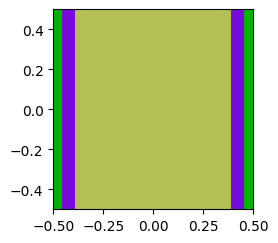

In [38]:
z_min = openmc.ZPlane(-50.0, boundary_type='vacuum')
z_max = openmc.ZPlane(50.0, boundary_type='vacuum')
for cell_id, cell in pincell_model.geometry.get_all_cells().items():
    cell.region &= +z_min & -z_max

pincell_model.geometry.root_universe.plot(basis='xz')

Now we'll setup the tallies we need to get each of our values of interest.

As before, we'll want to know what cell contains our fuel.

In [39]:
fuel_cell = None
moderator_cell = None
for cell_id, cell in pincell_model.geometry.get_all_cells().items():
    print(cell.fill.name)
    if isinstance(cell.fill, openmc.Material) and cell.fill.name == 'UO2 (2.4%)':
        fuel_cell = cell
    if isinstance(cell.fill, openmc.Material) and cell.fill.name == 'Hot borated water':
        moderator_cell = cell
        
print(fuel_cell)
print(moderator_cell)

UO2 (2.4%)
Zircaloy
Hot borated water
Cell
	ID             =	8
	Name           =	Fuel
	Fill           =	Material 4
	Region         =	(-7 13 -14)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None

Cell
	ID             =	10
	Name           =	Water
	Fill           =	Material 6
	Region         =	(8 9 -10 11 -12 13 -14)
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



In [40]:
tallies = openmc.Tallies()

# Instantiate energy filter for multi-group cross-section Tallies
energy_filter = openmc.EnergyFilter([0., 0.625, 20.0e6])

# Instantiate flux Tally in moderator and fuel
flux_tally = openmc.Tally(name='flux')
flux_tally.filters = [openmc.CellFilter([fuel_cell, moderator_cell])]
flux_tally.filters.append(energy_filter)
flux_tally.scores = ['flux']
tallies.append(flux_tally)

# Instantiate reaction rate Tally in fuel
fuel_rxn_tally = openmc.Tally(name='fuel rxn rates')
fuel_rxn_tally.filters = [openmc.CellFilter(fuel_cell)]
fuel_rxn_tally.filters.append(energy_filter)
fuel_rxn_tally.scores = ['nu-fission', 'scatter']
fuel_rxn_tally.nuclides = ['U238', 'U235']
tallies.append(fuel_rxn_tally)

# Instantiate reaction rate Tally in moderator
mod_rxn_tally = openmc.Tally(name='moderator rxn rates')
mod_rxn_tally.filters = [openmc.CellFilter(moderator_cell)]
mod_rxn_tally.filters.append(energy_filter)
mod_rxn_tally.scores = ['absorption', 'total']
mod_rxn_tally.nuclides = ['O16', 'H1']
tallies.append(mod_rxn_tally)

# Instantiate a tally mesh
mesh = openmc.RegularMesh()
mesh.dimension = [1, 1, 1]
mesh.lower_left = [-0.63, -0.63, -50.0]
mesh.width = [1.26, 1.26, 100.0]
meshsurface_filter = openmc.MeshSurfaceFilter(mesh)

# Instantiate thermal, fast, and total leakage tallies
leak_tally = openmc.Tally(name='leakage')
leak_tally.filters = [meshsurface_filter]
leak_tally.scores = ['current']
tallies.append(leak_tally)

thermal_leak = openmc.Tally(name='thermal leakage')
thermal_leak.filters = [meshsurface_filter, openmc.EnergyFilter([0., 0.625])]
thermal_leak.scores = ['current']
tallies.append(thermal_leak)

fast_leak = openmc.Tally(name='fast leakage')
fast_leak.filters = [meshsurface_filter, openmc.EnergyFilter([0.625, 20.0e6])]
fast_leak.scores = ['current']
tallies.append(fast_leak)

In [41]:
# K-Eigenvalue (infinity) tallies
fiss_rate = openmc.Tally(name='fiss. rate')
abs_rate = openmc.Tally(name='abs. rate')
fiss_rate.scores = ['nu-fission']
abs_rate.scores = ['absorption']
tallies += (fiss_rate, abs_rate)

In [42]:
# Resonance Escape Probability tallies
therm_abs_rate = openmc.Tally(name='therm. abs. rate')
therm_abs_rate.scores = ['absorption']
therm_abs_rate.filters = [openmc.EnergyFilter([0., 0.625])]
tallies.append(therm_abs_rate)

In [43]:
# Thermal Flux Utilization tallies
fuel_therm_abs_rate = openmc.Tally(name='fuel therm. abs. rate')
fuel_therm_abs_rate.scores = ['absorption']
fuel_therm_abs_rate.filters = [openmc.EnergyFilter([0., 0.625]),
                               openmc.CellFilter([fuel_cell])]
tallies.append(fuel_therm_abs_rate)

In [44]:
# Fast Fission Factor tallies
therm_fiss_rate = openmc.Tally(name='therm. fiss. rate')
therm_fiss_rate.scores = ['nu-fission']
therm_fiss_rate.filters = [openmc.EnergyFilter([0., 0.625])]
tallies.append(therm_fiss_rate)

In [45]:
pincell_model.tallies = tallies

Now we can adjust settings and run our model!

In [46]:
pincell_model.settings.particles = 2500
pincell_model.settings.batches = 20
pincell_model.settings.inactive = 5

sp_filename = pincell_model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/romano/openmc/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=8.
  warn(msg, IDWarning)
/home/romano/openmc/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=5.
  warn(msg, IDWarning)


 Reading Zr90 from /opt/data/hdf5/nndc_hdf5_v15/Zr90.h5
 Reading Zr91 from /opt/data/hdf5/nndc_hdf5_v15/Zr91.h5
 Reading Zr92 from /opt/data/hdf5/nndc_hdf5_v15/Zr92.h5
 Reading Zr94 from /opt/data/hdf5/nndc_hdf5_v15/Zr94.h5
 Reading Zr96 from /opt/data/hdf5/nndc_hdf5_v15/Zr96.h5
 Reading H1 from /opt/data/hdf5/nndc_hdf5_v15/H1.h5
 Reading B10 from /opt/data/hdf5/nndc_hdf5_v15/B10.h5
 Reading B11 from /opt/data/hdf5/nndc_hdf5_v15/B11.h5
 Reading c_H_in_H2O from /opt/data/hdf5/nndc_hdf5_v15/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.15582
        2/1    1.16965
        3/1    1.11696
        4/1    1.

Next, we'll retrieve all of the tally information from our statepoint file.

In [47]:
with openmc.StatePoint(sp_filename) as sp:
    flux_tally_out = sp.get_tally(id=flux_tally.id)
    fuel_rxn_tally_out = sp.get_tally(id=fuel_rxn_tally.id)
    mod_rxn_tally_out = sp.get_tally(id=mod_rxn_tally.id)    
    leak_tally_out = sp.get_tally(id=leak_tally.id)
    thermal_leak_out = sp.get_tally(id=thermal_leak.id)
    fast_leak_out = sp.get_tally(id=fast_leak.id)  
    fiss_rate_out = sp.get_tally(id=fiss_rate.id)
    abs_rate_out = sp.get_tally(id=abs_rate.id)
    therm_abs_rate_out = sp.get_tally(id=therm_abs_rate.id)
    fuel_therm_abs_rate_out = sp.get_tally(id=fuel_therm_abs_rate.id)
    therm_fiss_rate_out = sp.get_tally(id=therm_fiss_rate.id)

Now we'll calculate k-eff using only $\nu$, the fission rate, the absorption rate, and the leakage.

In [48]:
# Get leakage as summation of all current values on the mesh fitler
leakage = leak_tally_out.summation(filter_type=openmc.MeshSurfaceFilter, remove_filter=True)

In [49]:
type(fiss_rate)

openmc.tallies.Tally

In [50]:
keff = fiss_rate_out / (abs_rate_out + leakage)
keff.get_pandas_dataframe()

,nuclide,score,mean,std. dev.
0,total,(nu-fission / (absorption + current)),1.114973,0.007833


We can see in this dataframe that the uncertainty of the k-eff value is also present. This is because the `openmc.Tally` class uses the [uncertainties](https://pypi.org/project/uncertainties/) package to combine these values.

In [51]:
from uncertainties import ufloat

In [52]:
a = ufloat(1.0, 0.1)
b = ufloat(2.0, 0.5)
a+b

3.0+/-0.5099019513592785

In [53]:
np.sqrt(0.1**2 + 0.5**2) 

0.5099019513592785

Now let's compute k-eff using the four-factor formula to get k-inf.

$$k_{inf} = p \epsilon f \eta_{T} $$


To do this we'll need to compute each of these factors in turn. Starting with the resonance escape probability, $p$

$$p=\frac{\langle\Sigma_a\phi\rangle_T + \langle L \rangle_T}{\langle\Sigma_a\phi\rangle + \langle L \rangle_T}$$

where $T$ denotes a value tallied in the thermal range of the energy spectrum ($< \sim1eV$).

In [54]:
thermal_leak_out = thermal_leak_out.summation(filter_type=openmc.MeshSurfaceFilter, remove_filter=True)

res_esc = (therm_abs_rate_out + thermal_leak_out) / (abs_rate_out + thermal_leak_out)

res_esc.get_pandas_dataframe()

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.0,0.625,total,((absorption + current) / (absorption + current)),0.670389,0.005139


Next, we'll compute the fast fission factor, $\epsilon$:

$$\epsilon=\frac{\langle\nu\Sigma_f\phi\rangle}{\langle\nu\Sigma_f\phi\rangle_T}$$



In [55]:
fast_fiss = fiss_rate_out / therm_fiss_rate_out
fast_fiss.get_pandas_dataframe()

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.0,0.625,total,(nu-fission / nu-fission),1.230271,0.010806


Next is the thermal flux utilization, $f$:

$$f=\frac{\langle\Sigma_a\phi\rangle^F_T}{\langle\Sigma_a\phi\rangle_T}$$

In [56]:
therm_util = fuel_therm_abs_rate_out / therm_abs_rate_out
therm_util.get_pandas_dataframe()

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.0,0.625,8,total,(absorption / absorption),0.793665,0.007483


Finally, we'll compute the number of neutrons per fission, $\eta$:

$$\eta = \frac{\langle \nu\Sigma_f\phi \rangle_T}{\langle \Sigma_a \phi \rangle^F_T}$$

In [57]:
eta = therm_fiss_rate_out / fuel_therm_abs_rate_out
eta.get_pandas_dataframe()

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.0,0.625,8,total,(nu-fission / absorption),1.776463,0.017362


And now we can compute our four-factor k-inf value!

In [58]:
k_inf = res_esc * fast_fiss * therm_util * eta
k_inf.get_pandas_dataframe()

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.0,0.625,8,total,(((((absorption + current) / (absorption + cur...,1.162843,0.020812


Now let's take this a step further and compute the fast and thermal non-leakage probabilities ($P_{FNL}$ and $P_{TNL}$, respectively) to complete a six-factor formula estimation of k-eff

$$k_{eff} = p \epsilon f \eta P_{FNL} P_{TNL}$$

First, $P_{FNL}$.

$$P_{FNL} = \frac{\langle \Sigma_a\phi \rangle + \langle L \rangle_T}{\langle \Sigma_a \phi \rangle + \langle L \rangle}$$

In [59]:
p_fnl = (abs_rate_out + thermal_leak_out) / (abs_rate_out + leakage)
p_fnl.get_pandas_dataframe()

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.0,0.625,total,((absorption + current) / (absorption + current)),0.96408,0.005922


and now $P_{TNL}$

$$P_{TNL} = \frac{\langle \Sigma_a\phi \rangle_T}{\langle \Sigma_a \phi \rangle_T + \langle L \rangle_T}$$

In [60]:
p_tnl = therm_abs_rate_out / (therm_abs_rate_out + thermal_leak_out)
p_tnl.get_pandas_dataframe()

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.0,0.625,total,(absorption / (absorption + current)),0.994558,0.009011


In [61]:
keff = res_esc * fast_fiss * therm_util * eta * p_fnl * p_tnl
keff.get_pandas_dataframe()

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.0,0.625,8,total,(((((((absorption + current) / (absorption + c...,1.114973,0.023392
